In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("./data/train.csv")
df.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


In [3]:
# 欠損値補完
df["name"] = df["name"].str.replace("あんかけ", "あん")
df["name"] = df["name"].str.replace("厚切り", "厚切")
df["name"] = df["name"].str.replace("ひれかつ", "ヒレカツ")
df["kcal"] = df.groupby("name")["kcal"].bfill()
df["kcal"] = df.groupby("name")["kcal"].ffill()
print(df.head())
print(df["kcal"].isnull().sum())

     datetime    y week  soldout        name   kcal remarks event  payday  \
0  2013-11-18   90    月        0     厚切イカフライ  400.0     NaN   NaN     NaN   
1  2013-11-19  101    火        1     手作りヒレカツ  428.0     NaN   NaN     NaN   
2  2013-11-20  118    水        0  白身魚唐揚げ野菜あん  436.0     NaN   NaN     NaN   
3  2013-11-21  120    木        1      若鶏ピリ辛焼    NaN     NaN   NaN     NaN   
4  2013-11-22  130    金        1    ビッグメンチカツ    NaN     NaN   NaN     NaN   

  weather precipitation  temperature  
0      快晴            --         19.8  
1      快晴            --         17.0  
2      快晴            --         15.5  
3      快晴            --         15.2  
4      快晴            --         16.1  
26


In [4]:
df = df.fillna({"kcal": df["kcal"].mean(numeric_only=True)})
df.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切イカフライ,400.000000,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,428.000000,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,436.000000,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,405.519337,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,405.519337,NaN,NaN,NaN,快晴,--,16.1


In [5]:
df["precipitation"][df["precipitation"] == "--"] = 0

C:\Users\okazaki\AppData\Local\Temp\ipykernel_26192\3932859807.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["precipitation"][df["precipitation"] == "--"] = 0
C:\Users\okazaki\AppData\Local\Temp\ipykernel_26192\3932859807.py:1: Sett

In [6]:
df["payday"] = df["payday"].fillna(0.0)

In [7]:
df = df.astype({"payday": int, "precipitation": float})

In [8]:
# 曜日の数値化
df["week"] = df["week"].replace({"月": 0, "火": 1, "水": 2, "木": 3, "金": 4})
df["week_cos"] = np.cos(2 * np.pi * df["week"] / 7)
df["week_sin"] = np.sin(2 * np.pi * df["week"] / 7)

C:\Users\okazaki\AppData\Local\Temp\ipykernel_26192\3706727804.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["week"] = df["week"].replace({"月": 0, "火": 1, "水": 2, "木": 3, "金": 4})


In [9]:
# onehot-encoding
# df = pd.get_dummies(
#     df, columns=["week", "weather"], dtype=int, drop_first=True)
# df = pd.get_dummies(
#     df, columns=["weather"], dtype=int, drop_first=True)
# df = pd.get_dummies(df, columns=["remarks", "event"],
#                     dtype=int, drop_first=True, dummy_na=True)

In [10]:
X = df.drop(columns=["datetime", "y", "name", "weather", "remarks", "event", "week"])
y = df["y"]

In [11]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

import lightgbm as lgb

# kfoldの分割数
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2)

lgbm_params = {
    'objective': 'regression',
    'verbose': -1
    }

mse_list = []
rmse_list = []
r2_list = []

# kfoldで分割
for train_index, test_index in skf.split(X, y):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)

    # 学習
    model = lgb.train(lgbm_params, lgb_train)

    predict = model.predict(X_test, num_iteration=model.best_iteration)
    mse = mean_squared_error(y_test, predict)
    rmse = root_mean_squared_error(y_test, predict)
    r2 = r2_score(y_test, predict)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)

print(f"MSE: {np.mean(mse_list)}, RMSE: {np.mean(rmse_list)}, R2: {np.mean(r2_list)}")

MSE: 363.9920815064834, RMSE: 18.957228877222864, R2: 0.6547656890292595


c:\Users\okazaki\Desktop\MLコンペ\signate_practice\obento\env\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

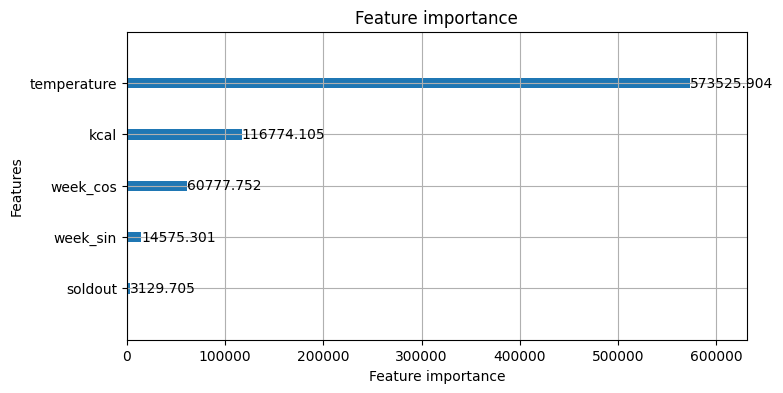

In [12]:
lgb.plot_importance(model, figsize=(8,4), max_num_features=10, importance_type='gain')

c:\Users\okazaki\Desktop\MLコンペ\signate_practice\obento\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


shap_values:  [[ 0.91614489  0.11027169  0.          0.         21.15799636  8.14447712
  -0.70376051]]
expected_value:  86.00000000783325


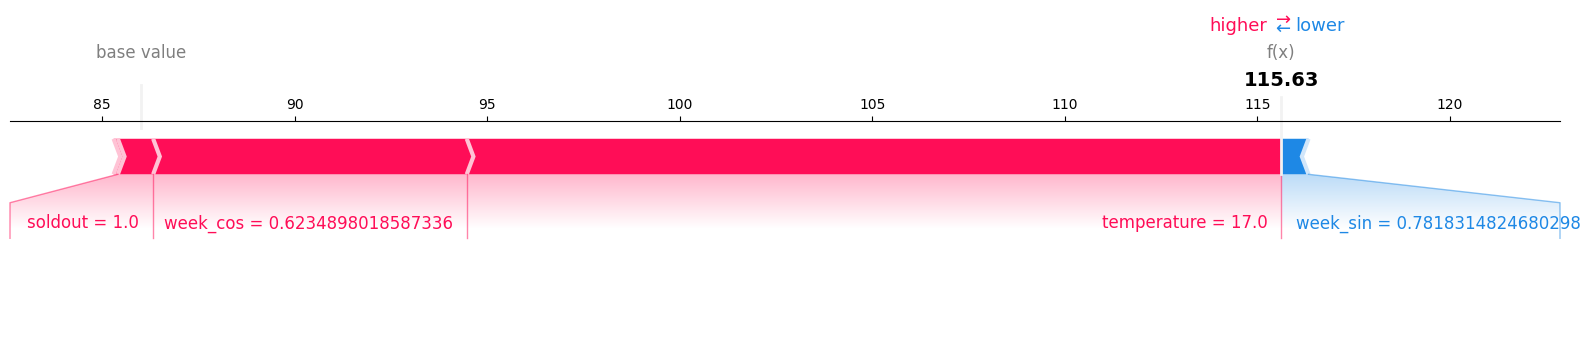

In [13]:
import shap

data_for_pred = pd.DataFrame([X_test.iloc[0, :]])

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_pred)
print('shap_values: ', shap_values)
print('expected_value: ', explainer.expected_value)

shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[0,:], features=data_for_pred.iloc[0,:], matplotlib=True)

In [14]:
data_for_pred

,soldout,kcal,payday,precipitation,temperature,week_cos,week_sin
1,1.0,428.0,0.0,0.0,17.0,0.62349,0.781831


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       207 non-null    object 
 1   y              207 non-null    int64  
 2   week           207 non-null    int64  
 3   soldout        207 non-null    int64  
 4   name           207 non-null    object 
 5   kcal           207 non-null    float64
 6   remarks        21 non-null     object 
 7   event          14 non-null     object 
 8   payday         207 non-null    int32  
 9   weather        207 non-null    object 
 10  precipitation  207 non-null    float64
 11  temperature    207 non-null    float64
 12  week_cos       207 non-null    float64
 13  week_sin       207 non-null    float64
dtypes: float64(5), int32(1), int64(3), object(5)
memory usage: 22.0+ KB
